# Mean Reversion Strategy Between Gold and Silver Using Linear Regression
This notebook demonstrates how to build a mean reversion trading strategy based on the relationship between gold and silver prices using linear regression.  
It includes:

- Data download and preparation  
- Exploratory data analysis and regression  
- Residual calculation and visualization  
- Signal generation based on residual thresholds  
- Threshold optimization using Sharpe ratio  
- **Walk-forward optimization** for realistic out-of-sample backtesting  
- Performance visualization and evaluation  

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats

## 1. Data Download and Preparation

We download historical closing prices of Gold and Silver futures from Yahoo Finance, from January 1, 2020 to today.  
We then merge the data into a single DataFrame and clean missing values.


In [38]:
# Define date range
start_date = "2020-01-01"
today = datetime.date.today()

# Download price data
gold = yf.download("GC=F", start=start_date, end=today)
silver = yf.download("SI=F", start=start_date, end=today)

# Merge close prices into one DataFrame
data = pd.concat([gold['Close'], silver['Close']], axis=1)
data.columns = ["Gold_Close", "Silver_Close"]

# Drop missing data
data = data.dropna()

/tmp/ipykernel_14110/1552358297.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold = yf.download("GC=F", start=start_date, end=today)
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_14110/1552358297.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  silver = yf.download("SI=F", start=start_date, end=today)
[*********************100%***********************]  1 of 1 completed


## 2. Exploratory Data Analysis

We visualize the price movements of Gold and Silver and compute their correlation.  
This gives us insight into their relationship.

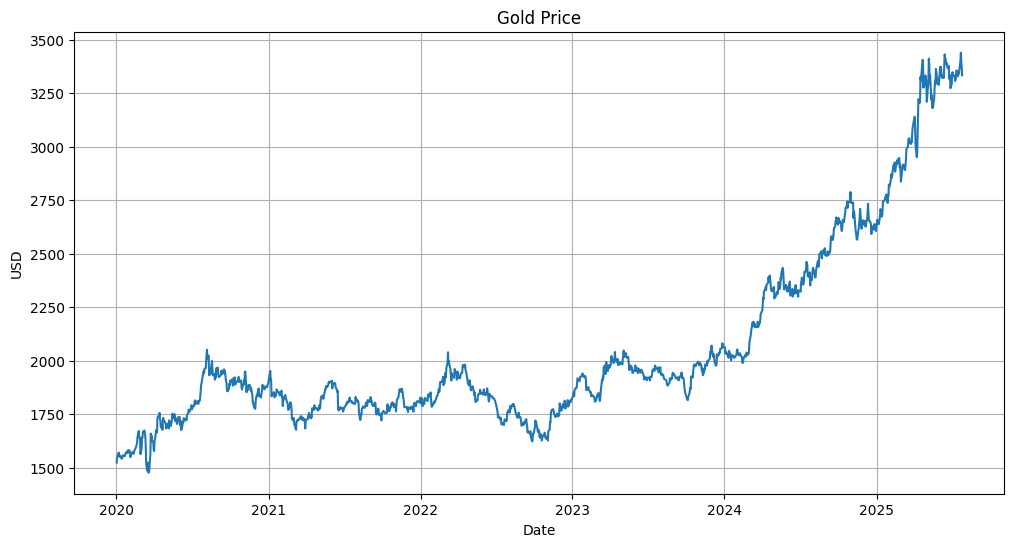

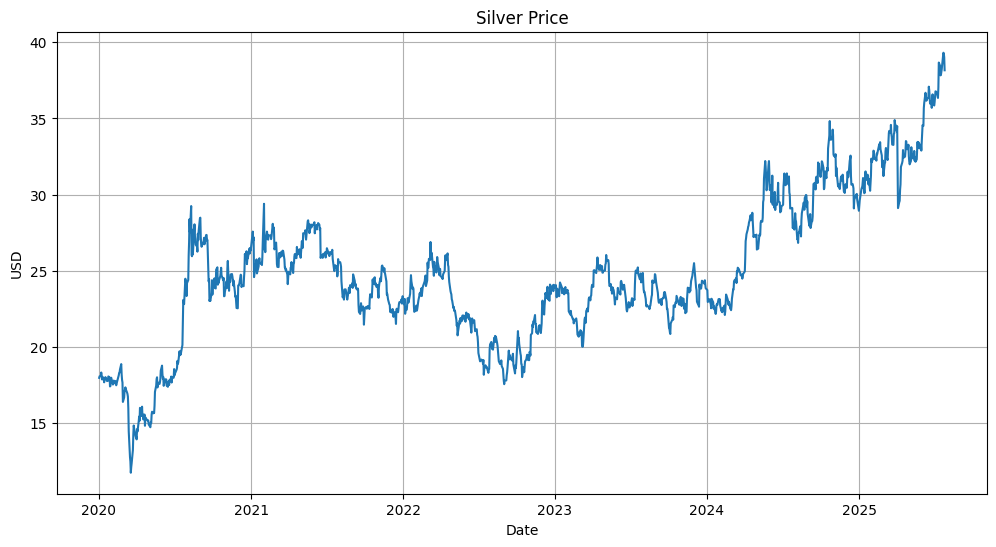

Correlation between Gold and Silver closing prices: 0.8636


In [43]:
# Plot Gold price
plt.figure(figsize=(12,6))
plt.plot(data["Gold_Close"])
plt.grid(True)
plt.title("Gold Price")
plt.xlabel("Date")
plt.ylabel("USD")
plt.show()

# Plot Silver price
plt.figure(figsize=(12,6))
plt.plot(data["Silver_Close"])
plt.grid(True)
plt.title("Silver Price")
plt.xlabel("Date")
plt.ylabel("USD")
plt.show()

# Compute correlation
corr = data["Gold_Close"].corr(data["Silver_Close"])
print(f"Correlation between Gold and Silver closing prices: {corr:.4f}")


## 3. Linear Regression to Predict Silver Price from Gold Price

We use linear regression to model Silver prices as a function of Gold prices.  
This step establishes the expected relationship between the two assets.


Regression equation: Silver = 0.0094 * Gold + 5.5278
R-squared: 0.7459


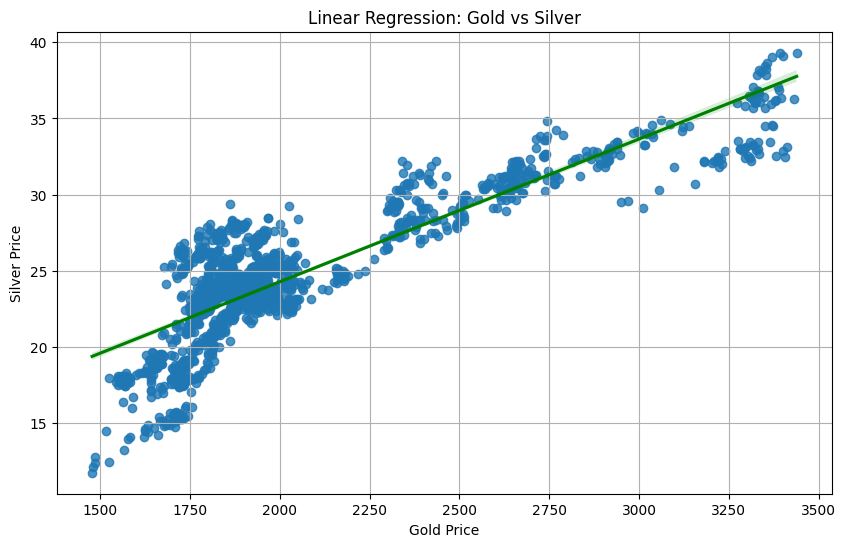

In [44]:
# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(
    data["Gold_Close"], data["Silver_Close"]
)

print(f"Regression equation: Silver = {slope:.4f} * Gold + {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")

# Plot regression line and data points
plt.figure(figsize=(10,6))
sns.regplot(x="Gold_Close", y="Silver_Close", data=data, line_kws={"color": "green"})
plt.grid(True)
plt.title("Linear Regression: Gold vs Silver")
plt.xlabel("Gold Price")
plt.ylabel("Silver Price")
plt.show()


## 4. Calculate Residuals and Visualize

Residuals are the differences between actual Silver prices and predicted prices from the regression.  
They indicate deviations from the expected relationship and are central to our mean reversion strategy.


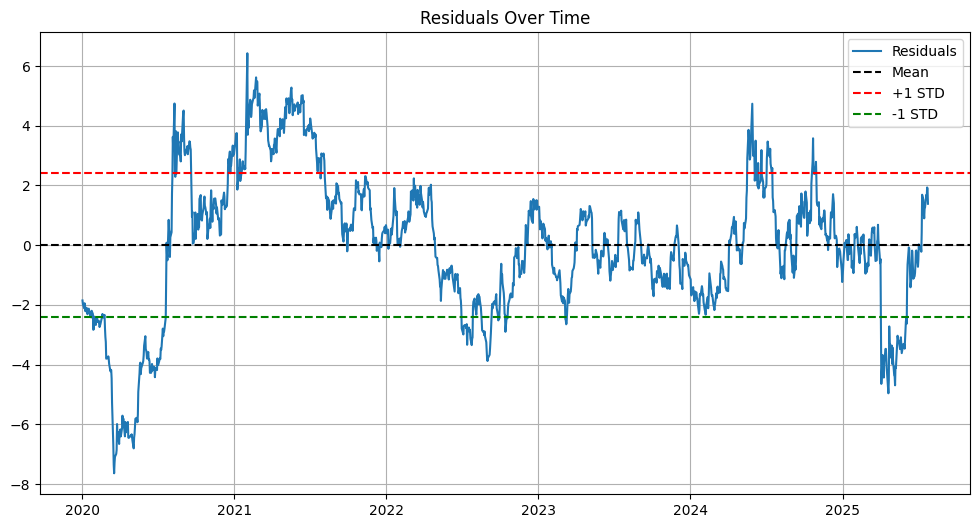

In [45]:
# Calculate predicted silver price and residuals
data["Predicted_Silver"] = slope * data["Gold_Close"] + intercept
data["Residuals"] = data["Silver_Close"] - data["Predicted_Silver"]

# Plot residuals with mean and ±1 standard deviation bands
plt.figure(figsize=(12,6))
plt.plot(data["Residuals"], label="Residuals")
plt.axhline(data["Residuals"].mean(), color='black', linestyle='--', label='Mean')
plt.axhline(data["Residuals"].mean() + data["Residuals"].std(), color='red', linestyle='--', label='+1 STD')
plt.axhline(data["Residuals"].mean() - data["Residuals"].std(), color='green', linestyle='--', label='-1 STD')
plt.grid(True)
plt.legend()
plt.title("Residuals Over Time")
plt.show()


## 5. Calculate Daily Returns

Calculate daily returns for Gold and Silver to use in our strategy return calculations.


In [46]:
# Define risk-free rate and trading days
risk_free_rate = 0.04  # 4% annual risk-free rate
trading_days = 252     # Trading days in a year
daily_rfr = (1 + risk_free_rate) ** (1 / trading_days) - 1  # Daily risk-free rate

# Calculate daily returns
data["Silver_Return"] = data["Silver_Close"].pct_change()
data["Gold_Return"] = data["Gold_Close"].pct_change()


## 6. Optimize Threshold for Trading Signals (In-Sample)

Test multiple thresholds (multiples of residual standard deviation) to find the best threshold that maximizes the Sharpe ratio on the entire dataset.  
Note: This is *not* realistic due to lookahead bias but useful for understanding the concept.


Best threshold: ±1.60 std with Sharpe ratio: 0.97


/tmp/ipykernel_14110/1343557986.py:15: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data["Position"] = data["Signal"].replace(to_replace=0, method='ffill')
/tmp/ipykernel_14110/1343557986.py:15: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data["Position"] = data["Signal"].replace(to_replace=0, method='ffill')
/tmp/ipykernel_14110/1343557986.py:15: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data["Position"] = data["Signal"].replace(to_replace=0, method='ffill')
/tmp/ipykernel_14110/1343557986.py:15: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data["Position"] = data["Signal"].replace(to_replace=0, method='ffill')
/tmp/ipykernel_14110/1343557986.py:15: FutureWarning: The 'method' keyword in Series.replace is deprecated and w

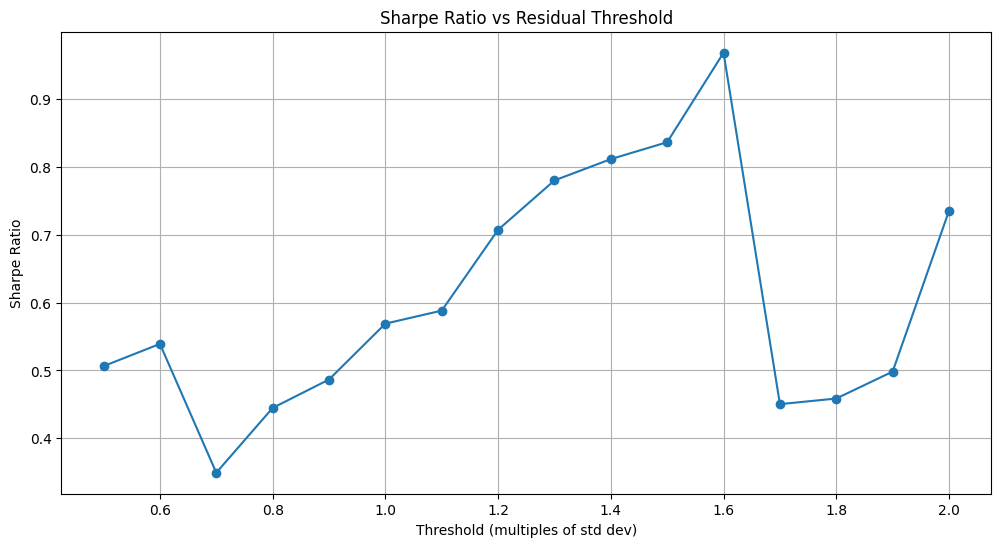

In [47]:
best_sharpe = -np.inf
best_thresh = None
results = []

# Test thresholds from 0.5 to 2.0 std dev
for k in np.arange(0.5, 2.05, 0.1):
    threshold = k * data["Residuals"].std()
    
    data["Signal"] = 0
    data.loc[data["Residuals"] > threshold, "Signal"] = -1
    data.loc[data["Residuals"] < -threshold, "Signal"] = 1
    
    residual_sign = np.sign(data["Residuals"])
    cross_zero = residual_sign != residual_sign.shift()
    data["Position"] = data["Signal"].replace(to_replace=0, method='ffill')
    data.loc[cross_zero, "Position"] = 0
    data["Position"] = data["Position"].fillna(0).shift(1).fillna(0)
    
    data["Strategy_Return"] = data["Position"] * (data["Silver_Return"] - data["Gold_Return"])
    data["Strategy_Return"] = data["Strategy_Return"].fillna(0)
    
    excess_return = data["Strategy_Return"] - daily_rfr
    sharpe = np.sqrt(trading_days) * excess_return.mean() / excess_return.std()
    
    results.append((k, sharpe))
    
    if sharpe > best_sharpe:
        best_sharpe = sharpe
        best_thresh = k

print(f"Best threshold: ±{best_thresh:.2f} std with Sharpe ratio: {best_sharpe:.2f}")

# Plot Sharpe ratio vs threshold
thresholds, sharpes = zip(*results)
plt.figure(figsize=(12,6))
plt.plot(thresholds, sharpes, marker='o')
plt.xlabel("Threshold (multiples of std dev)")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio vs Residual Threshold")
plt.grid(True)
plt.show()


## 7. Strategy Performance Using Best Threshold (In-Sample)

Generate trading signals and evaluate strategy performance with the best threshold found.


/tmp/ipykernel_14110/305305054.py:9: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data["Position"] = data["Signal"].replace(to_replace=0, method='ffill')


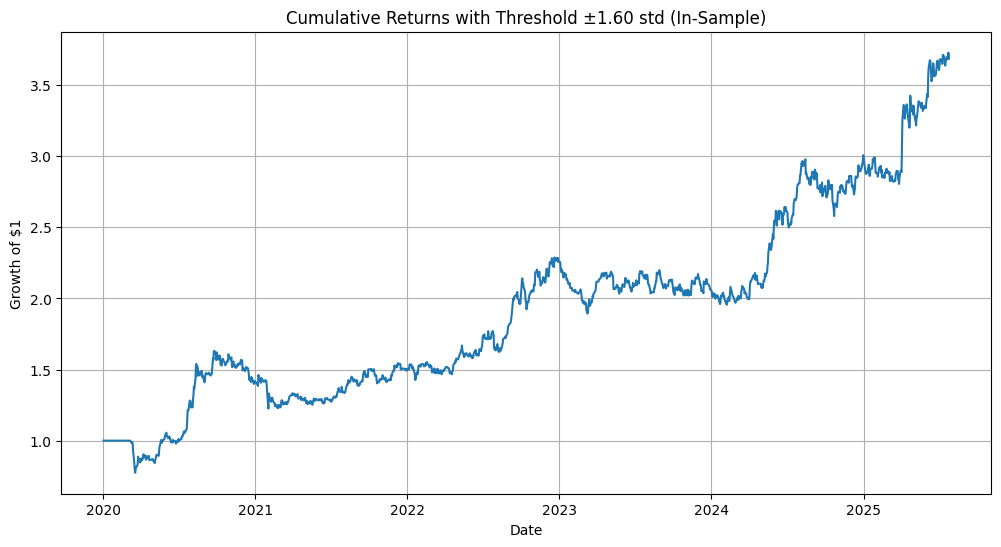

In [48]:
final_threshold = best_thresh * data["Residuals"].std()

data["Signal"] = 0
data.loc[data["Residuals"] > final_threshold, "Signal"] = -1
data.loc[data["Residuals"] < -final_threshold, "Signal"] = 1

residual_sign = np.sign(data["Residuals"])
cross_zero = residual_sign != residual_sign.shift()
data["Position"] = data["Signal"].replace(to_replace=0, method='ffill')
data.loc[cross_zero, "Position"] = 0
data["Position"] = data["Position"].fillna(0).shift(1).fillna(0)

data["Strategy_Return"] = data["Position"] * (data["Silver_Return"] - data["Gold_Return"])
data["Strategy_Return"] = data["Strategy_Return"].fillna(0)
data["Cumulative_Return"] = (1 + data["Strategy_Return"]).cumprod()

plt.figure(figsize=(12,6))
plt.plot(data["Cumulative_Return"])
plt.title(f"Cumulative Returns with Threshold ±{best_thresh:.2f} std (In-Sample)")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.grid(True)
plt.show()


## 8. Walk-Forward Optimization (Out-of-Sample)

To avoid lookahead bias and simulate realistic trading, we perform walk-forward optimization:  
- Find best threshold on past data (train window)  
- Apply on next future period (test window)  
- Roll forward and repeat  
- Combine all test period returns for final performance evaluation


/tmp/ipykernel_14110/1709517245.py:25: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  train_data["Position"] = train_data["Signal"].replace(to_replace=0, method='ffill')
/tmp/ipykernel_14110/1709517245.py:25: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  train_data["Position"] = train_data["Signal"].replace(to_replace=0, method='ffill')
/tmp/ipykernel_14110/1709517245.py:25: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  train_data["Position"] = train_data["Signal"].replace(to_replace=0, method='ffill')
/tmp/ipykernel_14110/1709517245.py:25: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  train_data["Position"] = train_data["Signal"].replace(to_replace=0, method='ffill')
/tmp/ipykernel_14110/1709517245.py:25: FutureWarning: The 'metho

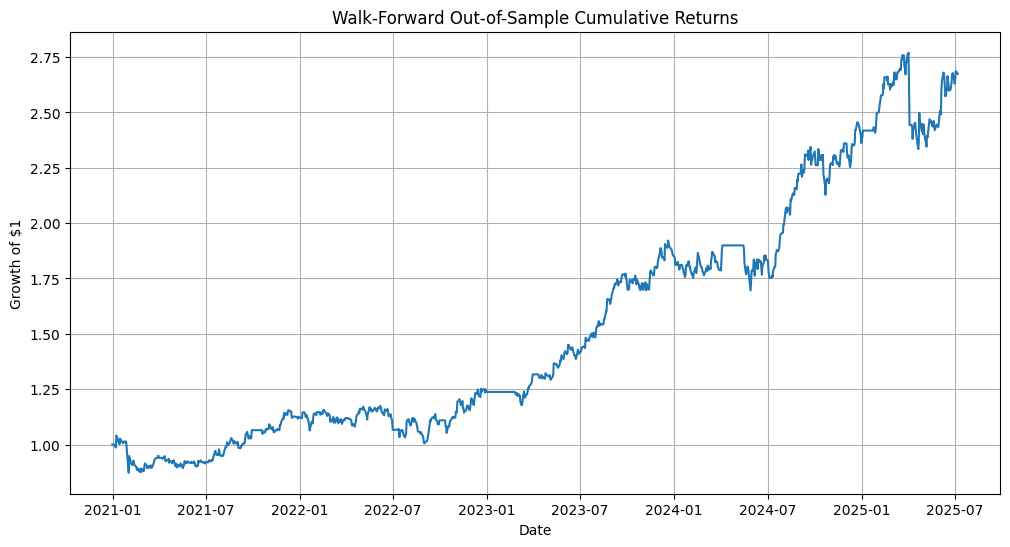

Walk-forward Sharpe Ratio: 1.01


In [49]:
window_train = 252  # 1 year for training
window_test = 63    # ~3 months for testing

start = 0
all_test_returns = []

while (start + window_train + window_test) < len(data):
    train_data = data.iloc[start : start + window_train].copy()
    test_data = data.iloc[start + window_train : start + window_train + window_test].copy()
    
    # Find best threshold on training window
    train_std = train_data["Residuals"].std()
    best_sharpe = -np.inf
    best_thresh = None
    
    for k in np.arange(0.5, 2.05, 0.1):
        threshold = k * train_std
        
        train_data["Signal"] = 0
        train_data.loc[train_data["Residuals"] > threshold, "Signal"] = -1
        train_data.loc[train_data["Residuals"] < -threshold, "Signal"] = 1
        
        residual_sign = np.sign(train_data["Residuals"])
        cross_zero = residual_sign != residual_sign.shift()
        train_data["Position"] = train_data["Signal"].replace(to_replace=0, method='ffill')
        train_data.loc[cross_zero, "Position"] = 0
        train_data["Position"] = train_data["Position"].fillna(0).shift(1).fillna(0)
        
        train_data["Strategy_Return"] = train_data["Position"] * (train_data["Silver_Return"] - train_data["Gold_Return"])
        train_data["Strategy_Return"] = train_data["Strategy_Return"].fillna(0)
        
        excess_return = train_data["Strategy_Return"] - daily_rfr
        sharpe = np.sqrt(trading_days) * excess_return.mean() / excess_return.std()
        
        if sharpe > best_sharpe:
            best_sharpe = sharpe
            best_thresh = k
    
    # Apply best threshold on test window
    test_std = test_data["Residuals"].std()
    threshold_test = best_thresh * test_std
    
    test_data["Signal"] = 0
    test_data.loc[test_data["Residuals"] > threshold_test, "Signal"] = -1
    test_data.loc[test_data["Residuals"] < -threshold_test, "Signal"] = 1
    
    residual_sign_test = np.sign(test_data["Residuals"])
    cross_zero_test = residual_sign_test != residual_sign_test.shift()
    test_data["Position"] = test_data["Signal"].replace(to_replace=0, method='ffill')
    test_data.loc[cross_zero_test, "Position"] = 0
    test_data["Position"] = test_data["Position"].fillna(0).shift(1).fillna(0)
    
    test_data["Strategy_Return"] = test_data["Position"] * (test_data["Silver_Return"] - test_data["Gold_Return"])
    test_data["Strategy_Return"] = test_data["Strategy_Return"].fillna(0)
    
    all_test_returns.append(test_data["Strategy_Return"])
    
    start += window_test  # Move forward the window

# Combine all out-of-sample returns
all_returns = pd.concat(all_test_returns)

# Plot cumulative returns from walk-forward out-of-sample testing
cumulative_return = (1 + all_returns).cumprod()

plt.figure(figsize=(12,6))
plt.plot(cumulative_return)
plt.title("Walk-Forward Out-of-Sample Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.grid(True)
plt.show()

# Calculate walk-forward Sharpe ratio
excess_return = all_returns - daily_rfr
walkforward_sharpe = np.sqrt(trading_days) * excess_return.mean() / excess_return.std()
print(f"Walk-forward Sharpe Ratio: {walkforward_sharpe:.2f}")


## 9. Comparison with S&P 500 Performance

We compare the out-of-sample performance of our mean reversion strategy with the S&P 500 index over the same period.  
This will show if the strategy can beat the broader market.


/tmp/ipykernel_14110/554065091.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start=data.index.min(), end=data.index.max())
[*********************100%***********************]  1 of 1 completed


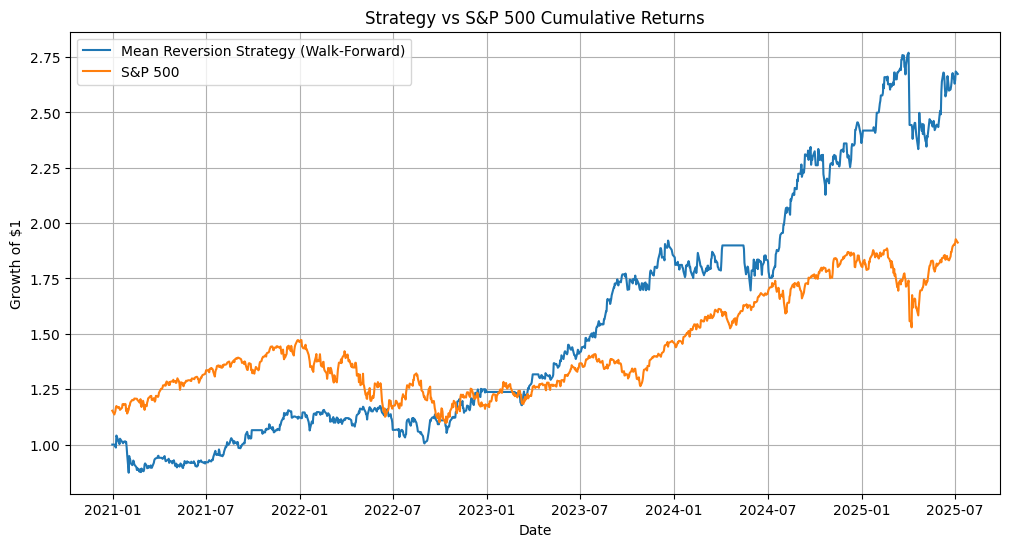

Total return of strategy (walk-forward): 167.36%
Total return of S&P 500: 91.23%
Strategy outperformance: 76.13%


In [54]:
# Download S&P 500 data for the same date range
sp500 = yf.download("^GSPC", start=data.index.min(), end=data.index.max())
sp500 = sp500["Close"].dropna()

# Calculate daily returns and cumulative returns of S&P 500
sp500_returns = sp500.pct_change().fillna(0)
sp500_cum_returns = (1 + sp500_returns).cumprod()

# Align index with strategy returns cumulative series
common_index = cumulative_return.index.intersection(sp500_cum_returns.index)

plt.figure(figsize=(12,6))
plt.plot(cumulative_return.loc[common_index], label="Mean Reversion Strategy (Walk-Forward)")
plt.plot(sp500_cum_returns.loc[common_index], label="S&P 500")
plt.title("Strategy vs S&P 500 Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.show()

# Performance summary
strategy_total_return = cumulative_return.loc[common_index].values[-1].item() - 1
sp500_total_return = sp500_cum_returns.loc[common_index].values[-1].item() - 1

print(f"Total return of strategy (walk-forward): {strategy_total_return:.2%}")
print(f"Total return of S&P 500: {sp500_total_return:.2%}")
print(f"Strategy outperformance: {(strategy_total_return - sp500_total_return):.2%}")



